                                                        
# TEXT MINING PROJECT


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
#!pip install wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
#!pip install prettytable
from prettytable import PrettyTable
from sklearn.linear_model import RidgeClassifier, LogisticRegression
import seaborn as sns

### Loading data

Dataset chosen for project contains information about coronavirus tweets. Dataset provide details about time and place of publishing tweet, tweet content and sentiment.
It has 44955 observations with no null values. For analysis purposes I only use two following columns:
- OriginalTweet - content of the tweet,
- Sentiment - tone of the tweet.


In [2]:
data_train = pd.read_csv("data/Corona_NLP_train.csv", encoding='latin_1')
data_test = pd.read_csv("data/Corona_NLP_test.csv", encoding='latin_1')
data_coronavirus = pd.concat([data_train.iloc[:,4:], data_test.iloc[:, 4:]])
data_coronavirus.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
data_coronavirus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


Random samples of positive, neutral and negative tweets

In [4]:
pd.options.display.max_colwidth = 200
data_coronavirus[data_coronavirus['Sentiment'] == 'Positive']['OriginalTweet'].sample().head()

1100    At the usual prices or even a bit less Rather than being the wealthy to afford and the poor surrender to their own fate I am afraid the be an excuse to all prices rising I know measures are taken ...
Name: OriginalTweet, dtype: object

In [5]:
data_coronavirus[data_coronavirus['Sentiment'] == 'Neutral']['OriginalTweet'].sample().head()

28186    #Content #CoronaVirus \r\r\nAm I Doing it right? About to head to the supermarket https://t.co/8GVGuS9HtS
Name: OriginalTweet, dtype: object

In [6]:
data_coronavirus[data_coronavirus['Sentiment'] == 'Negative']['OriginalTweet'].sample().head()

16818    With oil prices falling amid the COVID 19 recession it s the beginning of the end for fracking
Name: OriginalTweet, dtype: object

### Preparing for data cleanig
##### Functions:
- `cleaning()` - removing users names, urls, hashtags, digits, html tags, special characters
- `stop_words()` - removing english stop words 
- `stemming()` - stemming with lemmantization
- `text_tokenizer()` - recalling previous functions (cleaning, stop_words, stemming), removing words with less than 3 letters
 

In [7]:
def cleaning(text: str) -> str:
    patterns = [r'@[A-Za-z0-9-_]+',  
                r'http[s]?://\S+',
                r'#[A-Za-z0-9_]+',
                r'[0-9]+',
                r'<.*?>',
                r'[^\w\s]',
                r'_']
    text = re.sub('|'.join(patterns), '', text)
    text = " ".join(text.split()).lower()
    return text

def stop_words(stem_words: list) -> list[str]:
    stopwords_en = stopwords.words('english')
    new_list = []
    for word in stem_words:
        if word not in stopwords_en:
            new_list.append(word)
    return new_list


def stemming(text: str) -> list[str]:
    word_tokens = word_tokenize(text)
    porter = PorterStemmer()
    stem_words = []
    for w in word_tokens:
        stem_words.append(porter.stem(w))
    return stem_words


def text_tokenizer(text: str) -> list:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return new_wordlist

### Data exploration

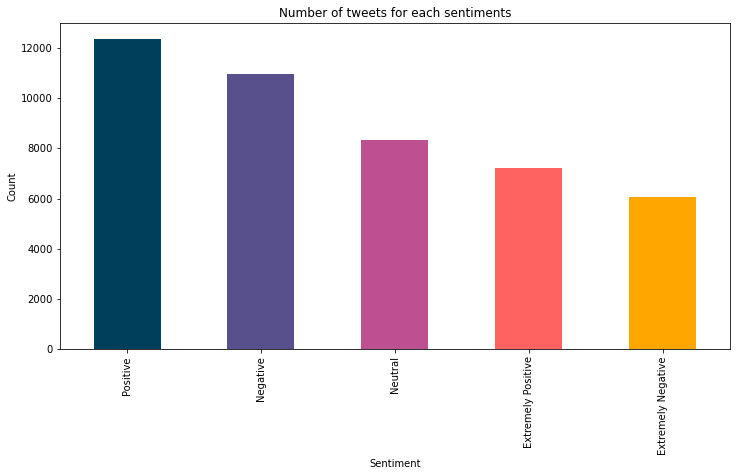

+--------------------+-------+
|     Sentiment      | Count |
+--------------------+-------+
|      Positive      | 12369 |
|      Negative      | 10958 |
|      Neutral       |  8332 |
| Extremely Positive |  7223 |
| Extremely Negative |  6073 |
+--------------------+-------+


In [8]:
plt.figure(figsize=(12,6))
plt.title("Number of tweets for each sentiments")
colors = ['#003f5c','#58508d', '#bc5090', '#ff6361', '#ffa600']
data_coronavirus['Sentiment'].value_counts().plot.bar(color=colors, legend=None)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
pretty_table = PrettyTable()
pretty_table.add_column("Sentiment", data_coronavirus['Sentiment'].value_counts().index)
pretty_table.add_column("Count", data_coronavirus['Sentiment'].value_counts())
print(pretty_table)

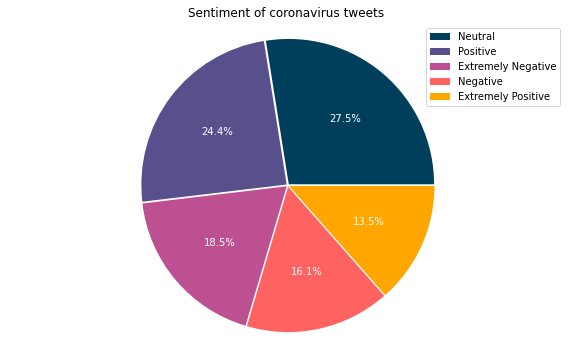

In [9]:
plt.figure(figsize=(10,6))
explode = (0.01,0.01 , 0.01, 0.01 , 0.01)
plt.pie(data_coronavirus['Sentiment'].value_counts(), colors=colors, labels=data_coronavirus['Sentiment'].unique(), autopct='%.1f%%', textprops={'color':"w"}, explode = explode)
plt.legend(loc='upper right')
plt.axis('equal')
plt.title("Sentiment of coronavirus tweets")
plt.show()

### Function for visualization
- `word_count()` - counting occurance of each word
- `cleaning_for_visualization()` - cleaning, stemming, removing stop words, removing words with less than three letters
- `compare_titles()` - finding words which not appear in different sentiment
- `visualization()` - barh plot and prettytable for visualization

In [10]:
def word_count(text: str) -> dict:
    word_tokens = word_tokenize(text)
    counts = dict()
    for word in word_tokens:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def cleaning_for_visualization(text: str) -> str:
    text = cleaning(text)
    stem_words = stemming(text)
    wordlist = stop_words(stem_words)
    new_wordlist = [w for w in wordlist if len(w) > 3]
    return " ".join(new_wordlist)
   
def compare_words(count_dict: dict, words: list) -> dict:
    unique_title = {}
    for values in count_dict.values():
        for key, value in values.items():
            if key not in words:
                unique_title[key] = value
    return unique_title

def visualization(data, title):
    plt.figure(figsize=(12,6))
    colors = ['#003f5c','#58508d', '#bc5090', '#ff6361', '#ffa600']
    data.plot.barh(title=title, color=np.random.choice(colors), legend=None).invert_yaxis()
    plt.xlabel("Count")
    plt.ylabel("Token")
    plt.show()
    pretty_table = PrettyTable()
    pretty_table.title = title
    pretty_table.add_column("Token", data.index)
    pretty_table.add_column("Count", data.iloc[:, 0])
    print(pretty_table)

Mapping the target column to: Negative, Neutral, Positive

In [11]:
data_coronavirus['Sentiment'] = data_coronavirus['Sentiment'].map({'Extremely Negative': 'Negative', 'Negative': 'Negative', 'Neutral': 'Neutral',
                                                                   'Positive':'Positive', 'Extremely Positive': 'Positive'})

#### Wordclouds

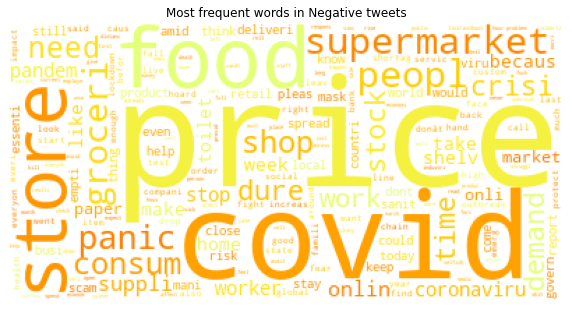

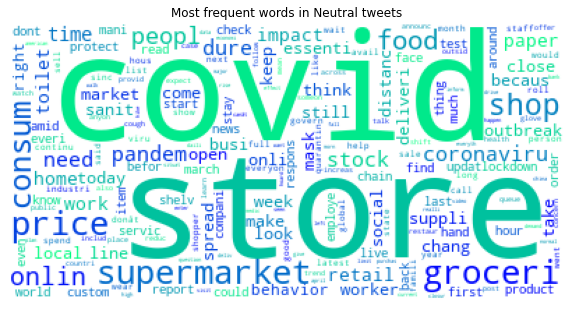

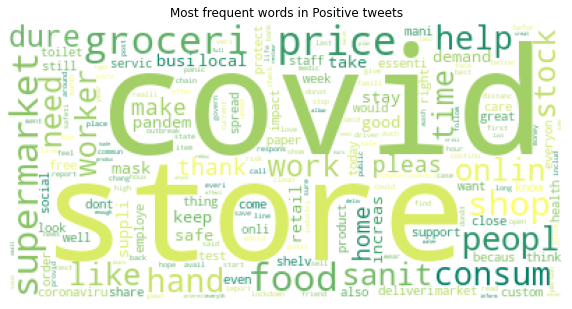

In [12]:
data_for_v = data_coronavirus[['OriginalTweet','Sentiment']].copy()
data_for_v['OriginalTweet'] = data_for_v['OriginalTweet'].apply(cleaning_for_visualization)
        
colormap = ['Wistia', 'winter', 'summer']
sentiment = ['Negative', 'Neutral', 'Positive']

for sentiment, theme in zip(sentiment, colormap):
    text = data_for_v.query('Sentiment == @sentiment')['OriginalTweet'].str.cat(sep=' ')
    plt.figure(figsize=[10, 8])
    wc = WordCloud(background_color="white", colormap=theme)
    wc.generate_from_frequencies(word_count(text))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Most frequent words in {sentiment} tweets")
    plt.show() 

### Vectorization

In [13]:
data_positive = data_coronavirus[data_coronavirus['Sentiment'] == 'Positive']
data_neutral = data_coronavirus[data_coronavirus['Sentiment'] == 'Neutral']
data_negative = data_coronavirus[data_coronavirus['Sentiment'] == 'Negative']

count_vec = CountVectorizer(tokenizer=text_tokenizer) 
count_vec1 = CountVectorizer(tokenizer=text_tokenizer)
count_vec2 = CountVectorizer(tokenizer=text_tokenizer)
X_transform_positive = count_vec.fit_transform(data_positive['OriginalTweet'])
X_transform_neutral = count_vec1.fit_transform(data_neutral['OriginalTweet'])
X_transform_negative = count_vec2.fit_transform(data_negative['OriginalTweet'])

In [14]:
tokens_count_positive = pd.DataFrame(X_transform_positive.sum(axis=0), columns=count_vec.get_feature_names())
tokens_count_neutral = pd.DataFrame(X_transform_neutral.sum(axis=0), columns=count_vec1.get_feature_names())
tokens_count_negative = pd.DataFrame(X_transform_negative.sum(axis=0), columns=count_vec2.get_feature_names())

In [15]:
positive_vs_negative = pd.DataFrame.from_dict(compare_words(tokens_count_positive.to_dict(orient="index"),
                                                             count_vec2.get_feature_names()),
                                              orient="index").sort_values(by=0, ascending=False).head(15)
negative_vs_positive = pd.DataFrame.from_dict(compare_words(tokens_count_negative.to_dict(orient="index"),
                                                             count_vec.get_feature_names()),
                                              orient="index").sort_values(by=0, ascending=False).head(15)
positive_vs_neutral = pd.DataFrame.from_dict(compare_words(tokens_count_positive.to_dict(orient="index"),
                                                            count_vec1.get_feature_names()),
                                             orient="index").sort_values(by=0, ascending=False).head(15)
negative_vs_neutral = pd.DataFrame.from_dict(compare_words(tokens_count_negative.to_dict(orient="index"),
                                                            count_vec1.get_feature_names()),
                                             orient="index").sort_values(by=0, ascending=False).head(15)

<Figure size 864x432 with 0 Axes>

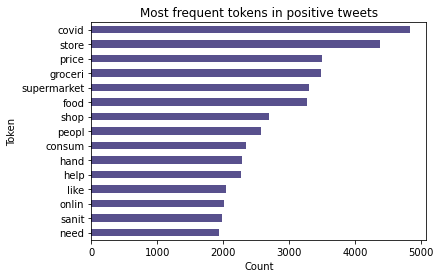

+-------------------------------------+
| Most frequent tokens in positive tweets |
+------------------------+------------+
|         Token          |   Count    |
+------------------------+------------+
|         covid          |    4836    |
|         store          |    4382    |
|         price          |    3499    |
|        groceri         |    3486    |
|      supermarket       |    3293    |
|          food          |    3264    |
|          shop          |    2691    |
|         peopl          |    2566    |
|         consum         |    2345    |
|          hand          |    2277    |
|          help          |    2262    |
|          like          |    2035    |
|         onlin          |    2005    |
|         sanit          |    1986    |
|          need          |    1942    |
+------------------------+------------+


<Figure size 864x432 with 0 Axes>

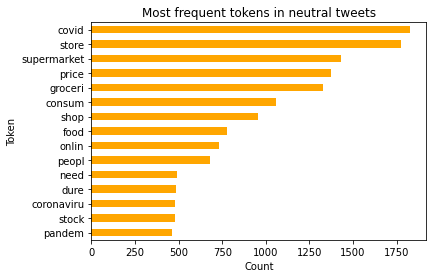

+------------------------------------+
| Most frequent tokens in neutral tweets |
+-----------------------+------------+
|         Token         |   Count    |
+-----------------------+------------+
|         covid         |    1828    |
|         store         |    1772    |
|      supermarket      |    1429    |
|         price         |    1373    |
|        groceri        |    1329    |
|         consum        |    1059    |
|          shop         |    957     |
|          food         |    779     |
|         onlin         |    734     |
|         peopl         |    680     |
|          need         |    493     |
|          dure         |    485     |
|       coronaviru      |    481     |
|         stock         |    480     |
|         pandem        |    459     |
+-----------------------+------------+


<Figure size 864x432 with 0 Axes>

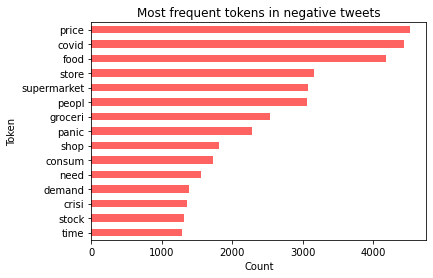

+-------------------------------------+
| Most frequent tokens in negative tweets |
+------------------------+------------+
|         Token          |   Count    |
+------------------------+------------+
|         price          |    4531    |
|         covid          |    4436    |
|          food          |    4189    |
|         store          |    3156    |
|      supermarket       |    3077    |
|         peopl          |    3069    |
|        groceri         |    2536    |
|         panic          |    2285    |
|          shop          |    1814    |
|         consum         |    1733    |
|          need          |    1551    |
|         demand         |    1381    |
|         crisi          |    1352    |
|         stock          |    1314    |
|          time          |    1293    |
+------------------------+------------+


In [16]:
visualization(tokens_count_positive.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in positive tweets")
visualization(tokens_count_neutral.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in neutral tweets")
visualization(tokens_count_negative.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in negative tweets")

<Figure size 864x432 with 0 Axes>

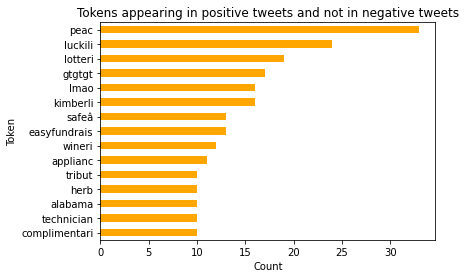

+-------------------------------------------------------+
| Tokens appearing in positive tweets and not in negative tweets |
+--------------------------------------+----------------+
|                Token                 |     Count      |
+--------------------------------------+----------------+
|                 peac                 |       33       |
|               luckili                |       24       |
|               lotteri                |       19       |
|                gtgtgt                |       17       |
|                 lmao                 |       16       |
|               kimberli               |       16       |
|                safeâ                 |       13       |
|             easyfundrais             |       13       |
|                wineri                |       12       |
|               applianc               |       11       |
|                tribut                |       10       |
|                 herb                 |       10       |
|    

<Figure size 864x432 with 0 Axes>

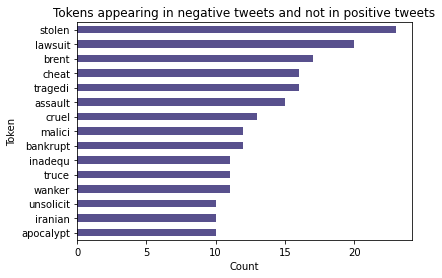

+----------------------------------------------------+
| Tokens appearing in negative tweets and not in positive tweets |
+--------------------------------+-------------------+
|             Token              |       Count       |
+--------------------------------+-------------------+
|             stolen             |         23        |
|            lawsuit             |         20        |
|             brent              |         17        |
|             cheat              |         16        |
|            tragedi             |         16        |
|            assault             |         15        |
|             cruel              |         13        |
|             malici             |         12        |
|            bankrupt            |         12        |
|            inadequ             |         11        |
|             truce              |         11        |
|             wanker             |         11        |
|           unsolicit            |         10        

<Figure size 864x432 with 0 Axes>

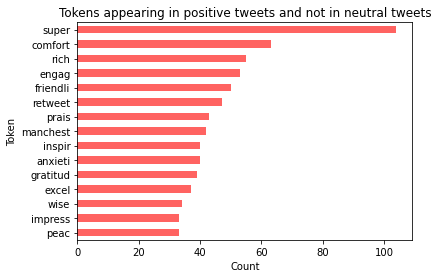

+---------------------------------------------------+
| Tokens appearing in positive tweets and not in neutral tweets |
+------------------------------+--------------------+
|            Token             |       Count        |
+------------------------------+--------------------+
|            super             |        104         |
|           comfort            |         63         |
|             rich             |         55         |
|            engag             |         53         |
|           friendli           |         50         |
|           retweet            |         47         |
|            prais             |         43         |
|           manchest           |         42         |
|            inspir            |         40         |
|           anxieti            |         40         |
|           gratitud           |         39         |
|            excel             |         37         |
|             wise             |         34         |
|           impr

<Figure size 864x432 with 0 Axes>

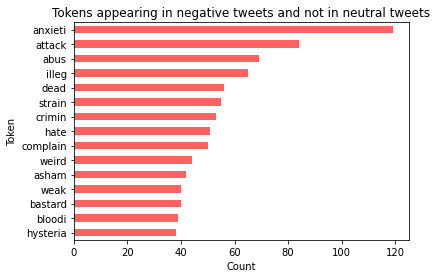

+---------------------------------------------------+
| Tokens appearing in negative tweets and not in neutral tweets |
+------------------------------+--------------------+
|            Token             |       Count        |
+------------------------------+--------------------+
|           anxieti            |        119         |
|            attack            |         84         |
|             abus             |         69         |
|            illeg             |         65         |
|             dead             |         56         |
|            strain            |         55         |
|            crimin            |         53         |
|             hate             |         51         |
|           complain           |         50         |
|            weird             |         44         |
|            asham             |         42         |
|             weak             |         40         |
|           bastard            |         40         |
|            blo

In [17]:
visualization(positive_vs_negative, "Tokens appearing in positive tweets and not in negative tweets")
visualization(negative_vs_positive, "Tokens appearing in negative tweets and not in positive tweets")
visualization(positive_vs_neutral, "Tokens appearing in positive tweets and not in neutral tweets")
visualization(negative_vs_neutral, "Tokens appearing in negative tweets and not in neutral tweets")

In [18]:
tfidf_vec = TfidfVectorizer(tokenizer=text_tokenizer) 
count_vec_all = CountVectorizer(tokenizer=text_tokenizer)
X_transform_tfidf = tfidf_vec.fit_transform(data_coronavirus['OriginalTweet'])
X_transform_count_all = count_vec_all.fit_transform(data_coronavirus['OriginalTweet'])

In [19]:
tokens_importance = pd.DataFrame(X_transform_tfidf.sum(axis=0), columns=tfidf_vec.get_feature_names())
tokens_count = pd.DataFrame(X_transform_count_all.sum(axis=0), columns=count_vec_all.get_feature_names())

<Figure size 864x432 with 0 Axes>

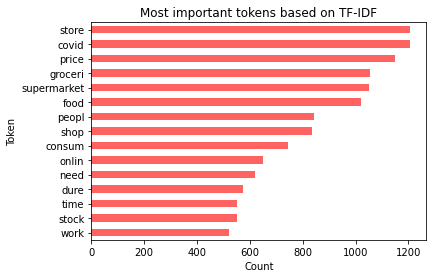

+----------------------------------------+
| Most important tokens based on TF-IDF  |
+---------------+------------------------+
|     Token     |         Count          |
+---------------+------------------------+
|     store     |   1207.1611759567618   |
|     covid     |   1204.3127617325665   |
|     price     |   1148.7074736125635   |
|    groceri    |   1053.8600922435812   |
|  supermarket  |   1049.5613193313097   |
|      food     |   1021.5967186874008   |
|     peopl     |   842.3608863313573    |
|      shop     |   835.6751592725961    |
|     consum    |   743.9048108883969    |
|     onlin     |    648.791296612381    |
|      need     |   619.3172941202843    |
|      dure     |   572.6522022819386    |
|      time     |   552.7181646127757    |
|     stock     |   549.7215631062234    |
|      work     |   521.5987938613596    |
+---------------+------------------------+


<Figure size 864x432 with 0 Axes>

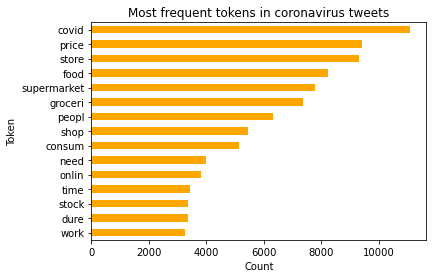

+---------------------------------------+
| Most frequent tokens in coronavirus tweets |
+-------------------------+-------------+
|          Token          |    Count    |
+-------------------------+-------------+
|          covid          |    11100    |
|          price          |     9403    |
|          store          |     9310    |
|           food          |     8232    |
|       supermarket       |     7799    |
|         groceri         |     7351    |
|          peopl          |     6315    |
|           shop          |     5462    |
|          consum         |     5137    |
|           need          |     3986    |
|          onlin          |     3824    |
|           time          |     3414    |
|          stock          |     3374    |
|           dure          |     3346    |
|           work          |     3272    |
+-------------------------+-------------+


In [20]:
visualization(tokens_importance.T.sort_values(by=0, ascending=False).head(15), "Most important tokens based on TF-IDF")
visualization(tokens_count.T.sort_values(by=0, ascending=False).head(15), "Most frequent tokens in coronavirus tweets")

## Classification

Splitting data into train and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_coronavirus['OriginalTweet'], data_coronavirus['Sentiment'],
                                                    test_size=0.2, shuffle=True, stratify=data_coronavirus['Sentiment'])

In [22]:
vectorizer = CountVectorizer(tokenizer=text_tokenizer)
count_train = vectorizer.fit_transform(X_train)
count_test = vectorizer.transform(X_test)

In [23]:
X_train.shape

(35964,)

In [24]:
X_test.shape

(8991,)

In [25]:
def heatmap(y_test, y_pred, classifier): 
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Purples", fmt='g', cbar=False),
    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'{classifier} Confusion Matrix')
    plt.show()

####  Random Forest Classifier

Random Forest Model 
               precision    recall  f1-score   support

    Negative       0.79      0.72      0.75      3406
     Neutral       0.67      0.74      0.70      1666
    Positive       0.79      0.82      0.81      3919

    accuracy                           0.77      8991
   macro avg       0.75      0.76      0.75      8991
weighted avg       0.77      0.77      0.77      8991



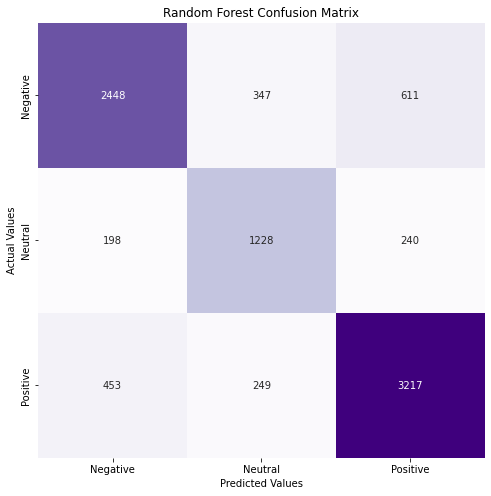

In [26]:
rfc_model = RandomForestClassifier()
rfc_model.fit(count_train, y_train)
rfc_predict = rfc_model.predict(count_test)
print(f'Random Forest Model \n {classification_report(y_test, rfc_predict)}')
heatmap(y_test, rfc_predict, "Random Forest")

#### Support Vector Machine

SVM Model 
               precision    recall  f1-score   support

    Negative       0.80      0.78      0.79      3406
     Neutral       0.67      0.70      0.68      1666
    Positive       0.82      0.82      0.82      3919

    accuracy                           0.78      8991
   macro avg       0.76      0.77      0.76      8991
weighted avg       0.78      0.78      0.78      8991



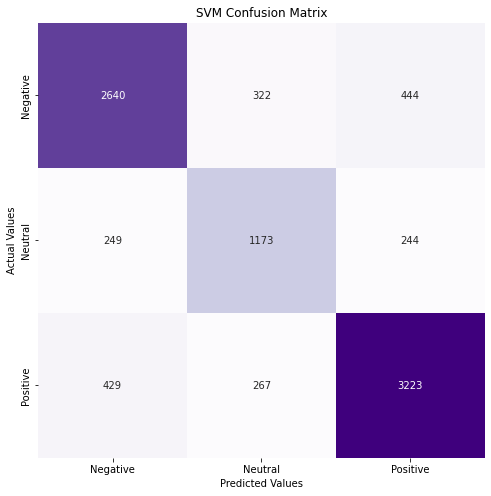

In [27]:
svm_model = LinearSVC(max_iter = 3000)
svm_model.fit(count_train, y_train)
svm_predict = svm_model.predict(count_test)
print(f'SVM Model \n {classification_report(y_test, svm_predict)}')
heatmap(y_test, svm_predict, "SVM")

#### Bagging

Bagging 
               precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      3406
     Neutral       0.68      0.72      0.70      1666
    Positive       0.79      0.77      0.78      3919

    accuracy                           0.74      8991
   macro avg       0.73      0.74      0.73      8991
weighted avg       0.74      0.74      0.74      8991



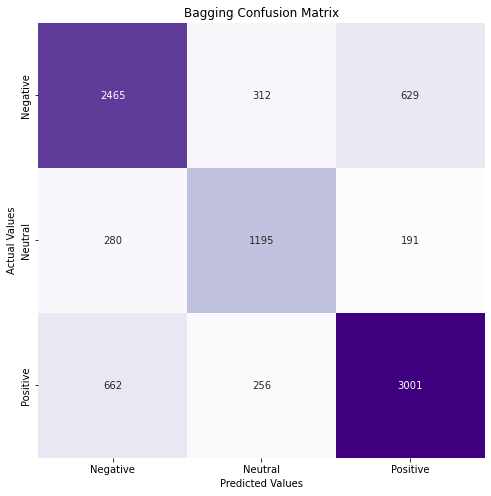

In [28]:
b_model = BaggingClassifier()
b_model.fit(count_train, y_train)
b_predict = b_model.predict(count_test)
print(f'Bagging \n {classification_report(y_test, b_predict)}')
heatmap(y_test, b_predict, "Bagging")

#### MLP Classifier

MLP Classifier Model 
               precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      3406
     Neutral       0.72      0.71      0.72      1666
    Positive       0.82      0.84      0.83      3919

    accuracy                           0.80      8991
   macro avg       0.78      0.78      0.78      8991
weighted avg       0.80      0.80      0.80      8991



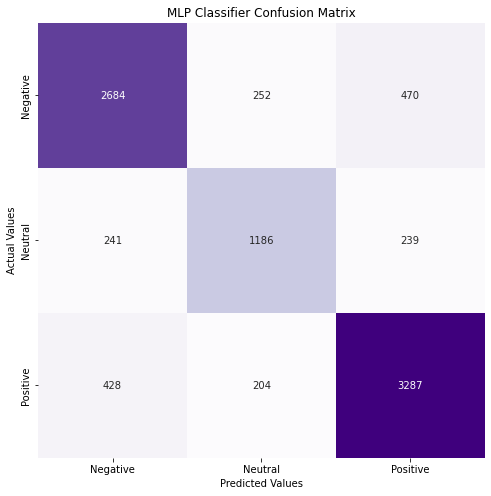

In [29]:
mlp=MLPClassifier(early_stopping=True)
mlp.fit(count_train, y_train)
mlp_predict=mlp.predict(count_test)
print(f'MLP Classifier Model \n {classification_report(y_test, mlp_predict)}')
heatmap(y_test, mlp_predict, "MLP Classifier")

#### Ridge Classifier

Ridge Classifier Model 
               precision    recall  f1-score   support

    Negative       0.77      0.76      0.77      3406
     Neutral       0.63      0.62      0.63      1666
    Positive       0.80      0.81      0.80      3919

    accuracy                           0.76      8991
   macro avg       0.73      0.73      0.73      8991
weighted avg       0.76      0.76      0.76      8991



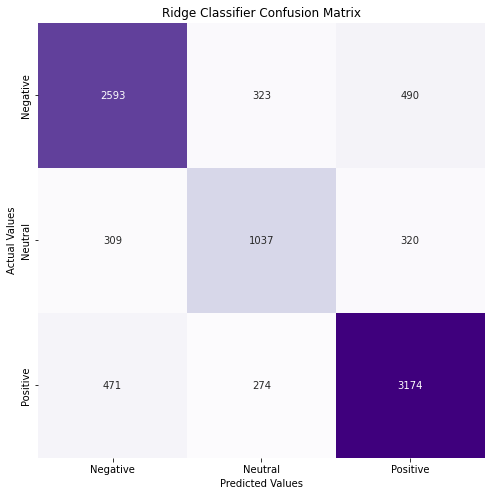

In [30]:
rc = RidgeClassifier()
rc.fit(count_train, y_train)
rc_predict =rc.predict(count_test)
print(f'Ridge Classifier Model \n {classification_report(y_test, rc_predict)}')
heatmap(y_test, rc_predict, "Ridge Classifier")

#### Logistic Regression

Logistic Model 
               precision    recall  f1-score   support

    Negative       0.81      0.78      0.80      3406
     Neutral       0.69      0.74      0.71      1666
    Positive       0.83      0.84      0.84      3919

    accuracy                           0.80      8991
   macro avg       0.78      0.79      0.78      8991
weighted avg       0.80      0.80      0.80      8991



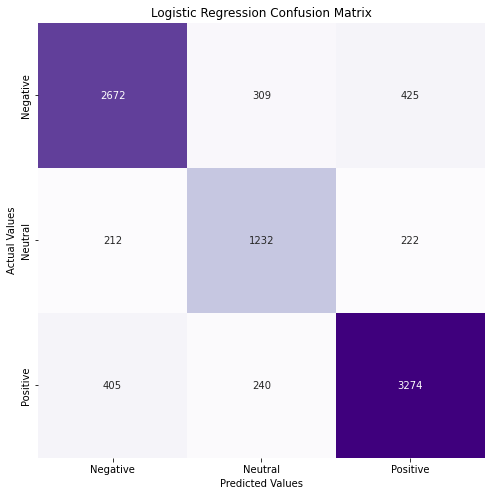

In [31]:
lr = LogisticRegression(max_iter = 3000)
lr.fit(count_train, y_train)
lr_predict = lr.predict(count_test)
print(f'Logistic Model \n {classification_report(y_test, lr_predict)}')
heatmap(y_test, lr_predict, "Logistic Regression")

### Conclusions

MLP Classifier and Logistic Regression performed best scores - 80% accurancy.

In [32]:
print(f'MLP Classifier Model \n {classification_report(y_test, mlp_predict)}')

MLP Classifier Model 
               precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      3406
     Neutral       0.72      0.71      0.72      1666
    Positive       0.82      0.84      0.83      3919

    accuracy                           0.80      8991
   macro avg       0.78      0.78      0.78      8991
weighted avg       0.80      0.80      0.80      8991



- Precision: Out of all the tweets that the model predicted is positive, 82% actually is.
- Recall: Out of all the tweets that actually is positive, the model  predicted this outcome correctly for 85% of those tweets.
- The best scores model performed for class 'Positive': f1-score = 84% and the worst for neutral: f1-score = 71% which is caused by class imbalance.

In [33]:
print(f'Logistic Model \n {classification_report(y_test, lr_predict)}')

Logistic Model 
               precision    recall  f1-score   support

    Negative       0.81      0.78      0.80      3406
     Neutral       0.69      0.74      0.71      1666
    Positive       0.83      0.84      0.84      3919

    accuracy                           0.80      8991
   macro avg       0.78      0.79      0.78      8991
weighted avg       0.80      0.80      0.80      8991



- Precision: Out of all the tweets that the model predicted is positive, 84% actually is.
- Recall: Out of all the tweets that actually is positive, the model predicted this outcome correctly for 84% of those tweets.
- The best scores model performed for class 'Positive': f1-score = 84% and the worst for neutral: f1-score = 70% which is caused by class imbalance.